# グラフマイニングの例
- [資料](./graph.md)

## 事前準備
- データセット
    - [social circles: Facebook](http://snap.stanford.edu/data/ego-Facebook.html) から facebook_combined.txt.zip をダウンロードし、展開。
- ツール等
    - [Graphviz](https://www.graphviz.org)
        - sfdp描画でエラーがでる場合には、以下の通りインストールし直そう。
        - ``brew remove graphviz``
        - ``brew install gts``
        - ``brew install graphviz``
    - [pygraphviz](https://pygraphviz.github.io)
        - ``pip install pygraphviz``
    - [networkx](https://networkx.github.io)
        - ``pip install networkx``

In [1]:
# データ読み込み

import pandas as pd

path = "/Users/tnal/2019/lecture/datamining/datasets/graph/ego-Facebook"
filename = "facebook_combined.txt"
full_filename = path + "/" + filename

df = pd.read_csv(full_filename, sep=' ')
df[:5]

,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [2]:
# エッジ数の確認（上位10件）

counts = df['0'].value_counts()
counts[:10]

107     1043
1684     778
1912     748
3437     542
0        346
348      225
1941     215
1985     207
483      191
1917     189
Name: 0, dtype: int64

In [3]:
# グラフ描画

import pygraphviz
import networkx as nx
import matplotlib.pyplot as plt

def from_edges_to_networks(filename):
    """グラフ読み込み
    Graphvizのラッパーであるpygraphvizにデータを渡すため、
    netoworkx.Graph()へノードとエッジ集合を読み込む。
    """
    G = nx.Graph()
    with open(filename) as fh:
        for line in fh:
            edges = list(map(int, line.split(" ")))
            G.add_edge(edges[0], edges[1])
    return G


G = nx.read_edgelist(full_filename, nodetype=int)
print(nx.number_of_nodes(G), nx.number_of_edges(G))


4039 88234


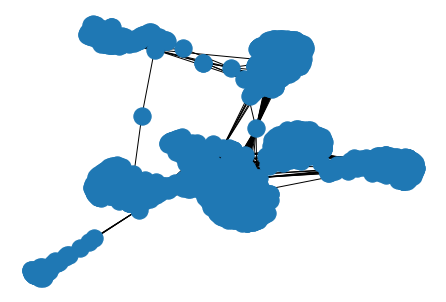

In [4]:
# そのまま描画すると潰れてしまう、、
nx.draw(G, prog='sfdp', args='-Goverlap=false -Tsvg')

In [5]:
# save graph
pos = nx.nx_agraph.pygraphviz_layout(G, prog='sfdp', args='-Goverlap=false -Tpng -o facebook.png')
!convert -resize 320x facebook.png facebook_s.png

![facebook_s.png](./facebook_s.png)

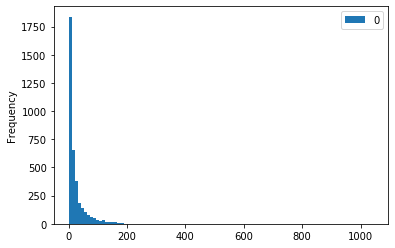

In [6]:
# plot the number of edges vs the frequency

%matplotlib inline

pd.DataFrame(counts).plot.hist(bins=100)

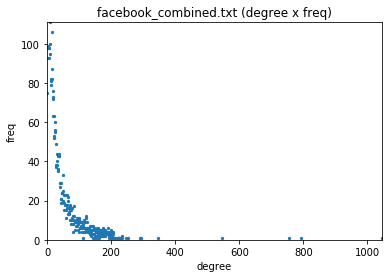

In [7]:
# degree distribution
# normal scale

import collections

# ノード毎に有するエッジ数をカウント
count = []
for index_of_node in G.adj:
    count.append(len(G.adj[index_of_node]))

count.sort()
temp = collections.Counter(count)

# エッジ数あたりの出現回数をカウント
degree, freq = zip(*temp.items())

plt.scatter(degree, freq, s=5)
plt.xlim(0, max(degree))
plt.ylim(0, max(freq))
plt.xlabel('degree')
plt.ylabel('freq')
plt.title(filename + ' (degree x freq)')
plt.show()


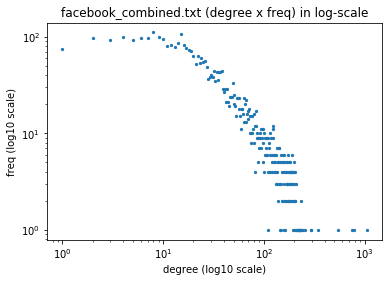

In [8]:
# log scale
plt.scatter(degree, freq, s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree (log10 scale)')
plt.ylabel('freq (log10 scale)')
plt.title(filename + ' (degree x freq) in log-scale')
plt.show()


## random surfer model
- dataset
    - [graph1.txt](./graph1.txt)
    - [graph2.txt](./graph2.txt)

In [9]:
import random

def random_surfer(G, max_itr=1000, d=0.15):
    """ランダムサーファーモデルのシミュレーション。
    ランダムなノードから出発し、そのページのout-edgesをランダムに選択して移動する。
    ただし、確率dでページ遷移を辞め、無作為にノードを選んで再出発する。

    :param G: networkx.classes.digraph.DiGraph。有向グラフ。
    :param max_itr: ページ遷移回数。
    :param d: エッジ選択から離脱する確率。
    :return: 各ノードの訪問割合。
    """
    num = len(nx.nodes(G))
    nodes = list(nx.nodes(G))
    reached = {}
    count = 0
    current = random.choice(nodes)
    while True:
        if current in reached:
            reached[current] += 1
        else:
            reached.update({current:1})
        count += 1
        if count == max_itr:
            break
        if d < random.random():
            targets = [target for cur, target in nx.edges(G, current)]
            if len(targets) == 0:
                break
            current = random.choice(targets)
        else:
            current = random.choice(nodes)
            continue
        print(count,reached)

    for node in reached.keys():
        reached[node] /= count
    return reached


filename = "graph1.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())
reached = random_surfer(G, 20)
print(reached)


1 {'D': 1}
2 {'D': 1, 'C': 1}
5 {'D': 1, 'C': 1, 'A': 2, 'B': 1}
6 {'D': 1, 'C': 2, 'A': 2, 'B': 1}
7 {'D': 1, 'C': 2, 'A': 3, 'B': 1}
8 {'D': 1, 'C': 2, 'A': 3, 'B': 2}
9 {'D': 1, 'C': 3, 'A': 3, 'B': 2}
10 {'D': 1, 'C': 3, 'A': 4, 'B': 2}
11 {'D': 1, 'C': 4, 'A': 4, 'B': 2}
12 {'D': 1, 'C': 4, 'A': 5, 'B': 2}
13 {'D': 1, 'C': 5, 'A': 5, 'B': 2}
14 {'D': 1, 'C': 5, 'A': 6, 'B': 2}
15 {'D': 1, 'C': 5, 'A': 6, 'B': 3}
17 {'D': 1, 'C': 6, 'A': 7, 'B': 3}
18 {'D': 1, 'C': 6, 'A': 7, 'B': 4}
19 {'D': 1, 'C': 7, 'A': 7, 'B': 4}
{'D': 0.05, 'C': 0.35, 'A': 0.4, 'B': 0.2}


## PageRank
- [NetworkX: pagerank](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html)
- dataset
    - [graph1.txt](./graph1.txt)
    - [graph2.txt](./graph2.txt)

{'A': 0.372526246091333, 'B': 0.19582365458881654, 'C': 0.39415009931985023, 'D': 0.037500000000000006}


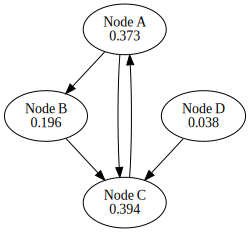

In [10]:
import networkx as nx

filename = "graph1.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())

# ランク算出
pr = nx.pagerank(G)
print(pr)

# グラフ描画
pos = nx.spring_layout(G)
labels = {}
for node in pr.keys():
    labels[node] = 'Node {}\n{}'.format(node, round(pr[node], 3))

G = nx.relabel_nodes(G, labels)

#nx.nx_agraph.view_pygraphviz(G, prog='sfdp')

import graphviz
graphviz.Source(nx.nx_agraph.to_agraph(G))

{'1': 0.12174896105921995, '2': 0.04386978407256124, '3': 0.04386978407256124, '4': 0.04386978407256124, '5': 0.06530818443477784, '6': 0.10217580762337017, '7': 0.07144359556771177, '8': 0.05279920075611914, '15': 0.14450495559625123, '9': 0.03181526582418545, '10': 0.05885906219895707, '11': 0.02188284889175391, '12': 0.02188284889175391, '13': 0.02188284889175391, '14': 0.02188284889175391, '16': 0.13220421915470792}


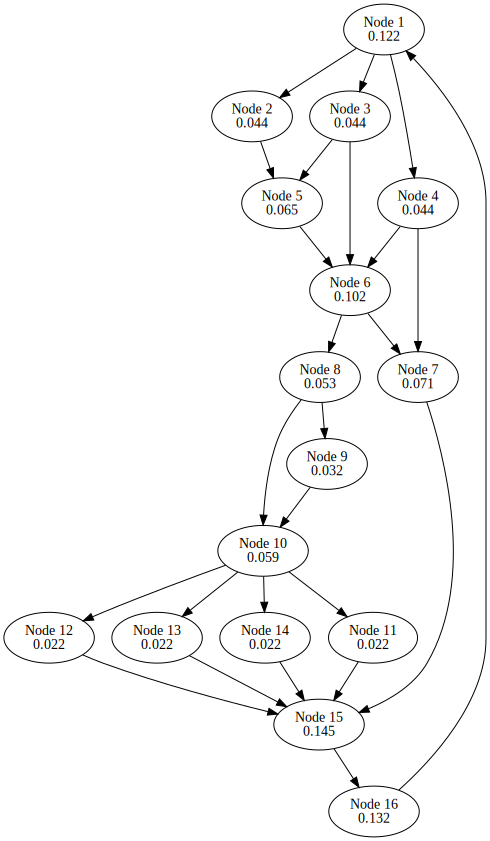

In [11]:
filename = "graph2.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())

# ランク算出
pr = nx.pagerank(G)
print(pr)

# グラフ描画
pos = nx.spring_layout(G)
labels = {}
for node in pr.keys():
    labels[node] = 'Node {}\n{}'.format(node, round(pr[node], 3))

G = nx.relabel_nodes(G, labels)

#nx.nx_agraph.view_pygraphviz(G, prog='sfdp')

import graphviz
graphviz.Source(nx.nx_agraph.to_agraph(G))
#nx.draw_networkx(G)

## コミュニティ検出
- [networkx.algorithms.community.centrality.girvan_newman](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman)
- dataset
    - [graph_modularity_simple.txt](./graph_modularity_simple.txt)

(['1', '2', '3', '4', '5'], ['A', 'B', 'C', 'D', 'E'])


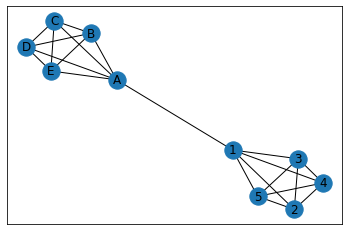

In [12]:
%matplotlib inline
from networkx.algorithms.community.centrality import girvan_newman

filename = "graph_modularity_simple.txt"
G = nx.read_edgelist(filename)

comp = girvan_newman(G)
print(tuple(sorted(c) for c in next(comp)))

#nx.nx_agraph.view_pygraphviz(G, prog='sfdp')
nx.draw_networkx(G)

In [13]:
from networkx import community

clusters = []
clusters.append([{'1', '2', '3', '4', '5'}, {'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'2', '3', '4', '5'}, {'1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'3', '4', '5'}, {'2', '1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'4', '5'}, {'2', '3', '1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'5'}, {'2', '3', '4', '1', 'A', 'B', 'C', 'D', 'E'}])

for i, cluster in enumerate(clusters):
    modularity = community.modularity(G, cluster)
    print('modularity(cluster{}) = {}'.format(i, modularity))


modularity(cluster0) = 0.45238095238095244
modularity(cluster1) = 0.28117913832199526
modularity(cluster2) = 0.1224489795918366
modularity(cluster3) = 0.02267573696145124
modularity(cluster4) = -0.018140589569160964
